# Sviluppo Prophet

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
from fbprophet import Prophet
import itertools
from fbprophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error
from sklearn import svm
from fbprophet.plot import add_changepoints_to_plot
warnings.filterwarnings('ignore')

### Per maggiori risorse oltre al sito di Prophet (https://facebook.github.io/prophet), https://facebook.github.io/prophet/docs/trend_changepoints.html

In [ ]:
dati = pd.read_csv('/content/drive/MyDrive/Data Science/Progetto Streaming Data/dati_preprocessati.csv')
dati.index.freq='H'
dati.rename(columns={"DataeOra": "ds", "Valore": "y",}, inplace=True)
dati.head()

,ds,Data,Ora,y,Mese,Giorno,Anno,Giornosettimana
0,2018-09-01 00:00:00,2018-09-01,0,3646742.0,9,1,2018,Saturday
1,2018-09-01 01:00:00,2018-09-01,1,3273110.0,9,1,2018,Saturday
2,2018-09-01 02:00:00,2018-09-01,2,3069245.0,9,1,2018,Saturday
3,2018-09-01 03:00:00,2018-09-01,3,2969621.0,9,1,2018,Saturday
4,2018-09-01 04:00:00,2018-09-01,4,2944116.0,9,1,2018,Saturday


In [ ]:
dati = dati[['ds', 'y']]
dati.head()

,ds,y
0,2018-09-01 00:00:00,3646742.0
1,2018-09-01 01:00:00,3273110.0
2,2018-09-01 02:00:00,3069245.0
3,2018-09-01 03:00:00,2969621.0
4,2018-09-01 04:00:00,2944116.0


# Modello 1 - Prophet

In [ ]:
train_dati = dati[dati['ds']<="2020-04-23 23:00:00"]
print("Numero di elementi presenti nel train: ", len(train_dati))
validation_dati = dati[dati['ds']>"2020-04-24 23:00:00"]
print("Numero di elementi presenti nel validation: ", len(validation_dati))

Numero di elementi presenti nel train:  14424
Numero di elementi presenti nel validation:  3096


In [ ]:
P_modello1 = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True) 
P_modello1.add_seasonality(name='monthly', period=30.5, fourier_order=2, prior_scale=0.02)

In [ ]:
P_modello1.fit(train_dati)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [ ]:
P_modello1.seasonalities

OrderedDict([('monthly',
              {'condition_name': None,
               'fourier_order': 2,
               'mode': 'additive',
               'period': 30.5,
               'prior_scale': 0.02}),
             ('yearly',
              {'condition_name': None,
               'fourier_order': 10,
               'mode': 'additive',
               'period': 365.25,
               'prior_scale': 10.0}),
             ('weekly',
              {'condition_name': None,
               'fourier_order': 3,
               'mode': 'additive',
               'period': 7,
               'prior_scale': 10.0}),
             ('daily',
              {'condition_name': None,
               'fourier_order': 4,
               'mode': 'additive',
               'period': 1,
               'prior_scale': 10.0})])

In [ ]:
future = P_modello1.make_future_dataframe(freq='H', periods=4416)

In [ ]:
future

,ds
0,2018-09-01 00:00:00
1,2018-09-01 01:00:00
2,2018-09-01 02:00:00
3,2018-09-01 03:00:00
4,2018-09-01 04:00:00
...,...
18835,2020-10-24 19:00:00
18836,2020-10-24 20:00:00
18837,2020-10-24 21:00:00
18838,2020-10-24 22:00:00


In [ ]:
#Predizioni sul validation e sul training:
prediction_train = P_modello1.predict(train_dati)
predict_validation = P_modello1.predict(validation_dati)

In [ ]:
#Mean Absolute Error 
def mean_absolute_error(y_true, y_pred): 
  return round(np.mean(np.abs(y_true - y_pred)), 1)

print("MAE train:", mean_absolute_error(train_dati['y'], prediction_train['yhat']))
print("MAE validation:", mean_absolute_error(validation_dati['y'].reset_index(drop=True), predict_validation['yhat']))

MAE train: 363690.4
MAE validation: 1068933.0


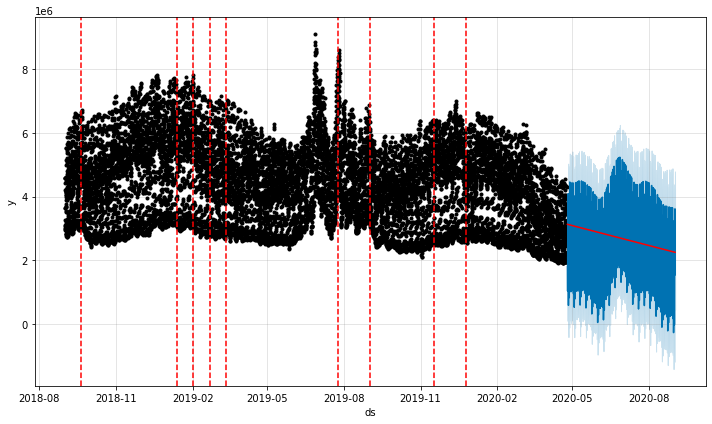

In [ ]:
forecast = P_modello1.predict(future)
fig = P_modello1.plot(predict_validation)
a = add_changepoints_to_plot(fig.gca(), P_modello1, predict_validation)

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
18835,2020-10-24 19:00:00,2.941351e+06,1.491522e+06,4.482149e+06
18836,2020-10-24 20:00:00,2.804769e+06,1.311122e+06,4.310852e+06
18837,2020-10-24 21:00:00,2.292437e+06,8.535151e+05,3.777496e+06
18838,2020-10-24 22:00:00,1.542915e+06,-4.376733e+03,3.007587e+06
18839,2020-10-24 23:00:00,7.855225e+05,-7.671193e+05,2.159832e+06


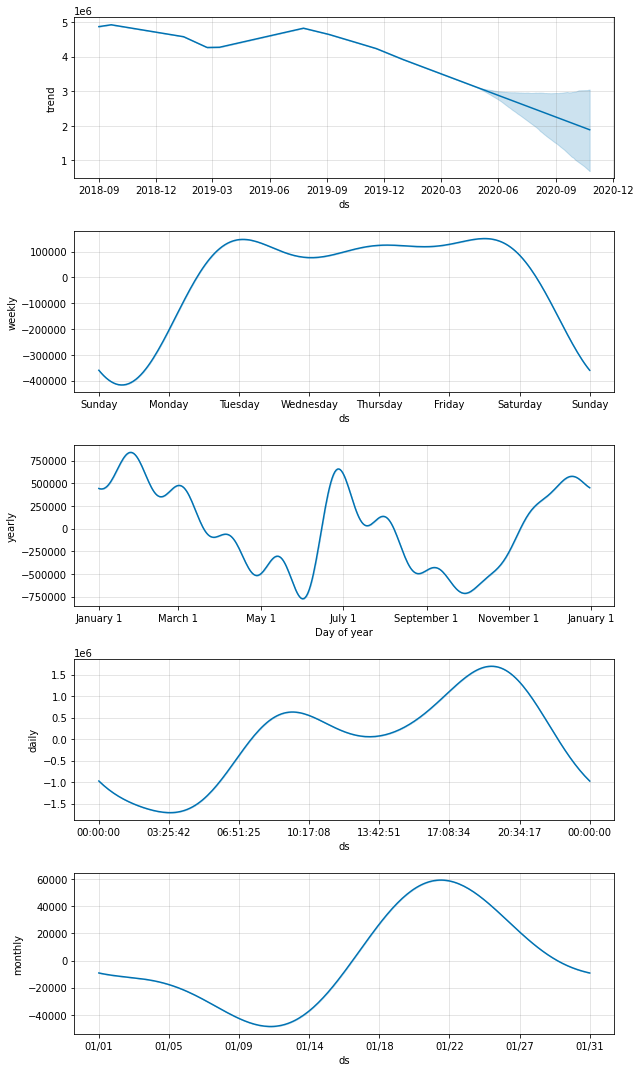

In [ ]:
fig2 = P_modello1.plot_components(forecast)

In [ ]:
from fbprophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(P_modello1, initial = '365 days', period = '30 days', horizon = '30 days')

df_cv.tail()

INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-09-26 23:00:00 and 2020-03-24 23:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
5035,2020-04-23 19:00:00,4.689376e+06,3.816911e+06,5.616617e+06,4005947.0,2020-03-24 23:00:00
5036,2020-04-23 20:00:00,4.560483e+06,3.656996e+06,5.415384e+06,4311509.0,2020-03-24 23:00:00
5037,2020-04-23 21:00:00,4.056835e+06,3.129177e+06,4.942483e+06,4032746.0,2020-03-24 23:00:00
5038,2020-04-23 22:00:00,3.317176e+06,2.448068e+06,4.176359e+06,3462387.0,2020-03-24 23:00:00
5039,2020-04-23 23:00:00,2.569995e+06,1.621493e+06,3.417940e+06,2928251.0,2020-03-24 23:00:00


In [ ]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,coverage
644,29 days 20:00:00,3.054519e+11,552677.032903,460655.569407,0.130390,0.114875,0.932540
645,29 days 21:00:00,3.120154e+11,558583.353893,464468.742642,0.131199,0.115550,0.930556
646,29 days 22:00:00,3.169068e+11,562944.729494,467528.664362,0.131880,0.116376,0.928571
647,29 days 23:00:00,3.209886e+11,566558.574364,471458.565861,0.132878,0.117817,0.926587
648,30 days 00:00:00,3.249400e+11,570035.104506,474672.829084,0.133787,0.119293,0.924603


# Modello 2 - Prophet

In [ ]:
train_dati = dati[dati['ds']<="2020-04-23 23:00:00"]
print("Numero di elementi presenti nel train: ", len(train_dati))
validation_dati = dati[dati['ds']>"2020-04-24 23:00:00"]
print("Numero di elementi presenti nel validation: ", len(validation_dati))

Numero di elementi presenti nel train:  14424
Numero di elementi presenti nel validation:  3096


In [ ]:
P_modello2 = Prophet(interval_width=0.95, yearly_seasonality=10, weekly_seasonality=3) 
P_modello2.add_seasonality(name='hourly', period=30.5, fourier_order=3, prior_scale=0.02)

In [ ]:
P_modello2.fit(train_dati)

In [ ]:
P_modello2.seasonalities

OrderedDict([('hourly',
              {'condition_name': None,
               'fourier_order': 3,
               'mode': 'additive',
               'period': 30.5,
               'prior_scale': 0.02}),
             ('yearly',
              {'condition_name': None,
               'fourier_order': 10,
               'mode': 'additive',
               'period': 365.25,
               'prior_scale': 10.0}),
             ('weekly',
              {'condition_name': None,
               'fourier_order': 3,
               'mode': 'additive',
               'period': 7,
               'prior_scale': 10.0}),
             ('daily',
              {'condition_name': None,
               'fourier_order': 4,
               'mode': 'additive',
               'period': 1,
               'prior_scale': 10.0})])

In [ ]:
future_2 = P_modello2.make_future_dataframe(freq='H', periods=4416)
future_2.tail()

,ds
18835,2020-10-24 19:00:00
18836,2020-10-24 20:00:00
18837,2020-10-24 21:00:00
18838,2020-10-24 22:00:00
18839,2020-10-24 23:00:00


In [ ]:
#Predizioni sul validation e sul training:
prediction_train_2 = P_modello2.predict(train_dati)
predict_validation_2 = P_modello2.predict(validation_dati)

In [ ]:
#Mean Absolute Error 
def mean_absolute_error(y_true, y_pred): 
  return round(np.mean(np.abs(y_true - y_pred)), 1)

print("MAE train:", mean_absolute_error(train_dati['y'], prediction_train_2['yhat']))
print("MAE validation:", mean_absolute_error(validation_dati['y'].reset_index(drop=True), predict_validation_2['yhat']))

MAE train: 363542.2
MAE validation: 1070384.8


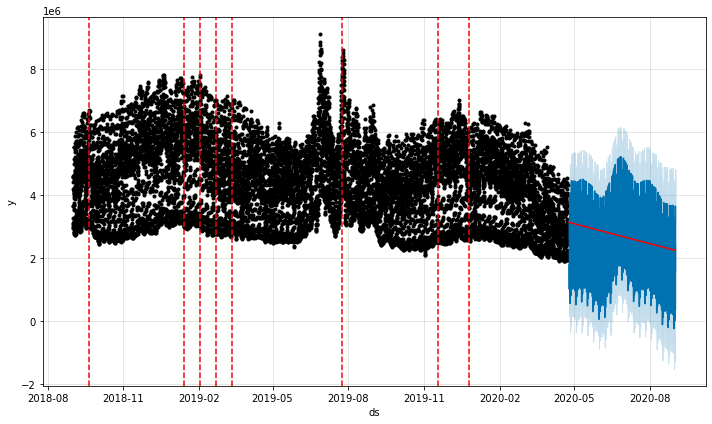

In [ ]:
forecast2 = P_modello2.predict(future_2)
fig = P_modello2.plot(predict_validation_2)
a = add_changepoints_to_plot(fig.gca(), P_modello2, predict_validation_2)

# Model 3 - Prophet

In [ ]:
train_dati = dati[dati['ds']<="2020-04-23 23:00:00"]
print("Numero di elementi presenti nel train: ", len(train_dati))
validation_dati = dati[dati['ds']>"2020-04-24 23:00:00"]
print("Numero di elementi presenti nel validation: ", len(validation_dati))

Numero di elementi presenti nel train:  14424
Numero di elementi presenti nel validation:  3096


In [ ]:
#Effettuato test aggiungendo anche un changepoints=['2020-03-07 00:00:00']
P_modello3 = Prophet(yearly_seasonality=True, weekly_seasonality=True, changepoint_prior_scale=0.01) 

In [ ]:
P_modello3.fit(train_dati)

In [ ]:
P_modello3.seasonalities

OrderedDict([('yearly',
              {'condition_name': None,
               'fourier_order': 10,
               'mode': 'additive',
               'period': 365.25,
               'prior_scale': 10.0}),
             ('weekly',
              {'condition_name': None,
               'fourier_order': 3,
               'mode': 'additive',
               'period': 7,
               'prior_scale': 10.0}),
             ('daily',
              {'condition_name': None,
               'fourier_order': 4,
               'mode': 'additive',
               'period': 1,
               'prior_scale': 10.0})])

In [ ]:
future_3 = P_modello3.make_future_dataframe(freq='H', periods=4416)
future_3.tail()

,ds
18835,2020-10-24 19:00:00
18836,2020-10-24 20:00:00
18837,2020-10-24 21:00:00
18838,2020-10-24 22:00:00
18839,2020-10-24 23:00:00


In [ ]:
#Predizioni sul validation e sul training:
prediction_train_3 = P_modello3.predict(train_dati)
predict_validation_3 = P_modello3.predict(validation_dati)

In [ ]:
#Mean Absolute Error 
def mean_absolute_error(y_true, y_pred): 
  return round(np.mean(np.abs(y_true - y_pred)), 1)

print("MAE train:", mean_absolute_error(train_dati['y'], prediction_train_3['yhat']))
print("MAE validation:", mean_absolute_error(validation_dati['y'].reset_index(drop=True), predict_validation_3['yhat']))

MAE train: 367052.2
MAE validation: 591879.7


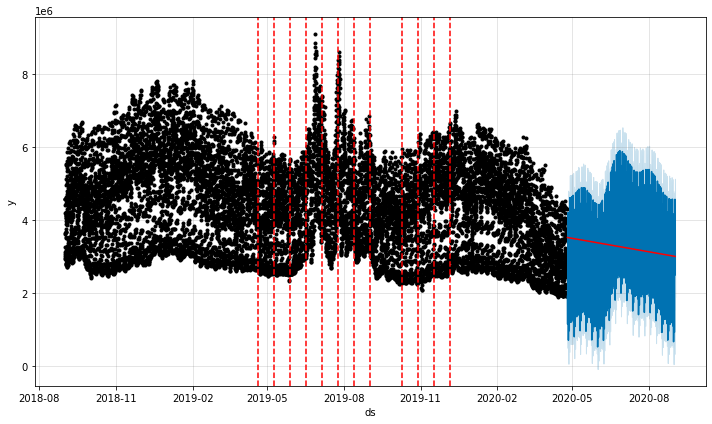

In [ ]:
fig = P_modello3.plot(predict_validation_3)
a = add_changepoints_to_plot(fig.gca(), P_modello3, predict_validation_3)

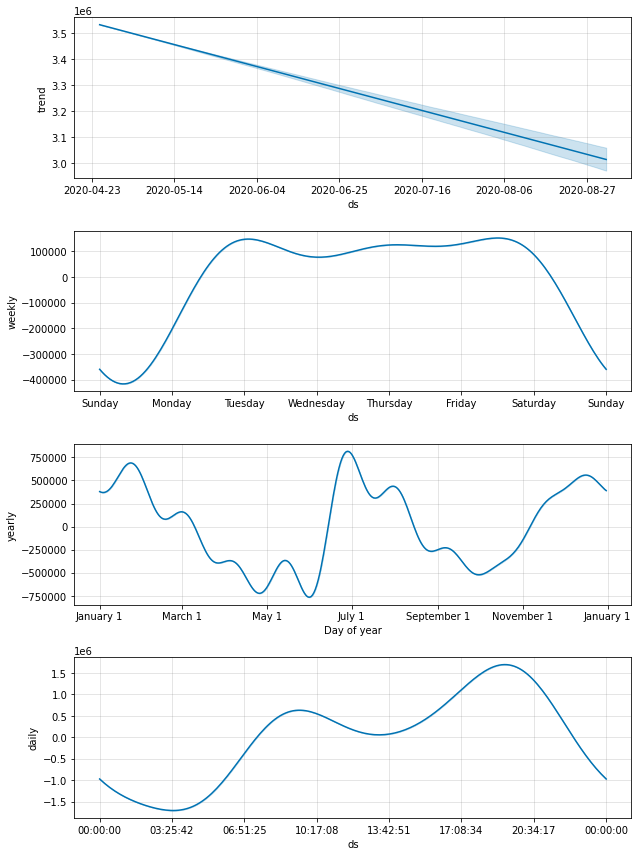

In [ ]:
 fig2 = P_modello3.plot_components(predict_validation_3)

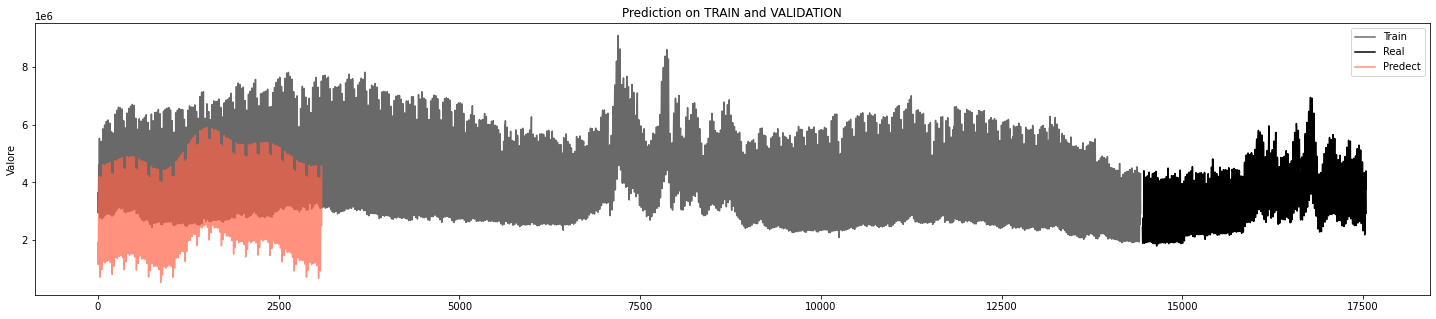

In [ ]:
plt.figure(figsize=(25, 5))
plt.title('Prediction on TRAIN and VALIDATION')
plt.plot(train_dati['y'], color='dimgrey', label='Train')
plt.plot(validation_dati['y'], color='black', label='Real')
plt.plot(predict_validation_3['yhat'], color='tomato', label='Predect', alpha=0.7)
plt.ylabel('Valore')
plt.legend()
plt.show()

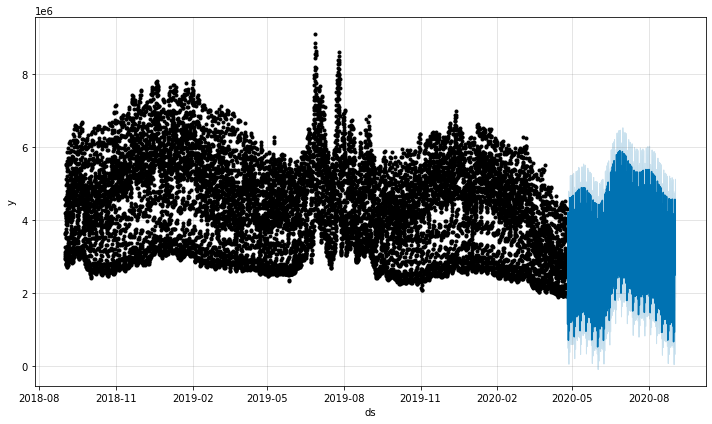

In [ ]:
fig = P_modello3.plot(predict_validation_3)

# Model 4 - Prophet

In [ ]:
#Effettuato test aggiungendo anche un changepoints=['2020-03-07 00:00:00']
#da mettere volendo : interval_width=0.95, 
#P_modello4 = Prophet(yearly_seasonality= True, weekly_seasonality = True, daily_seasonality='auto', mcmc_samples=30) 
#P_modello4.add_seasonality(name='weekly', period=168, fourier_order=5, prior_scale=0.1)
#buono mettendo nella seasonoality yearly 24*365,25 per il periodo
#P_modello4.add_seasonality(name='yearly', period=365.25, fourier_order=3, prior_scale=0.1)
#P_modello4.add_country_holidays(country_name='US')

In [ ]:
train_dati = dati[dati['ds']<="2020-04-23 23:00:00"]
print("Numero di elementi presenti nel train: ", len(train_dati))
validation_dati = dati[dati['ds']>"2020-04-24 23:00:00"]
print("Numero di elementi presenti nel validation: ", len(validation_dati))

Numero di elementi presenti nel train:  14424
Numero di elementi presenti nel validation:  3096


In [ ]:
#Effettuato test aggiungendo anche un changepoints=['2020-03-07 00:00:00']
#da mettere volendo : interval_width=0.95, 
P_modello4 = Prophet(yearly_seasonality= False, weekly_seasonality = False, daily_seasonality=False, mcmc_samples=30, changepoint_prior_scale=0.01, seasonality_prior_scale=0.01) 
P_modello4.add_seasonality(name='weekly', period=168, fourier_order=5, prior_scale=0.1)
#buono mettendo nella seasonoality yearly 24*365,25 per il periodo
P_modello4.add_seasonality(name='yearly', period=365.25, fourier_order=3, prior_scale=0.1)
P_modello4.add_seasonality(name='quarterly', period=365.25/4, fourier_order=5, prior_scale=0.1)
P_modello4.add_seasonality(name='daily', period=1, fourier_order=4, prior_scale=0.1)
P_modello4.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.1)
P_modello4.add_country_holidays(country_name='US')

In [ ]:
P_modello4.fit(train_dati)
print("FIT FATTO")

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


FIT FATTO


In [ ]:
P_modello4.seasonalities

OrderedDict([('weekly',
              {'condition_name': None,
               'fourier_order': 5,
               'mode': 'additive',
               'period': 168,
               'prior_scale': 0.1}),
             ('yearly',
              {'condition_name': None,
               'fourier_order': 3,
               'mode': 'additive',
               'period': 365.25,
               'prior_scale': 0.1}),
             ('quarterly',
              {'condition_name': None,
               'fourier_order': 5,
               'mode': 'additive',
               'period': 91.3125,
               'prior_scale': 0.1}),
             ('daily',
              {'condition_name': None,
               'fourier_order': 4,
               'mode': 'additive',
               'period': 1,
               'prior_scale': 0.1}),
             ('monthly',
              {'condition_name': None,
               'fourier_order': 5,
               'mode': 'additive',
               'period': 30.5,
               'prior_scale'

In [ ]:
future_4 = P_modello4.make_future_dataframe(freq='H', periods=4416)
future_4.tail()

,ds
18835,2020-10-24 19:00:00
18836,2020-10-24 20:00:00
18837,2020-10-24 21:00:00
18838,2020-10-24 22:00:00
18839,2020-10-24 23:00:00


In [ ]:
#Predizioni sul validation e sul training:
prediction_train_4 = P_modello4.predict(train_dati)
predict_validation_4 = P_modello4.predict(validation_dati)
print("PREDIZIONI FATTE")

PREDIZIONI FATTE


In [ ]:
#Mean Absolute Error 
def mean_absolute_error(y_true, y_pred): 
  return round(np.mean(np.abs(y_true - y_pred)), 1)

print("MAE train:", mean_absolute_error(train_dati['y'], prediction_train_4['yhat']))
print("MAE validation:", mean_absolute_error(validation_dati['y'].reset_index(drop=True), predict_validation_4['yhat']))

MAE train: 393593.6
MAE validation: 517896.7


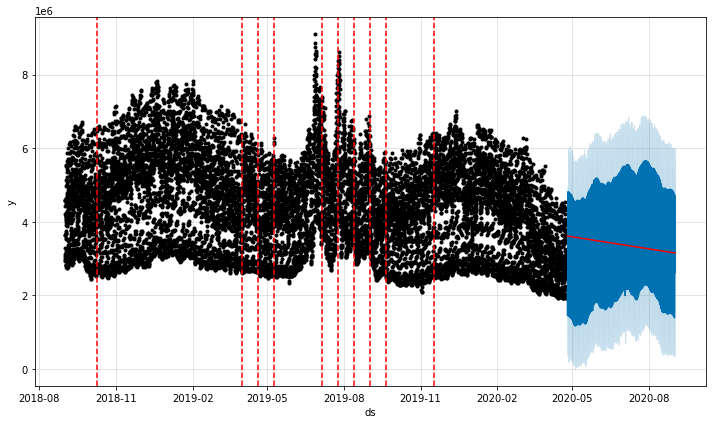

In [ ]:
fig = P_modello4.plot(predict_validation_4)
a = add_changepoints_to_plot(fig.gca(), P_modello4, predict_validation_4)

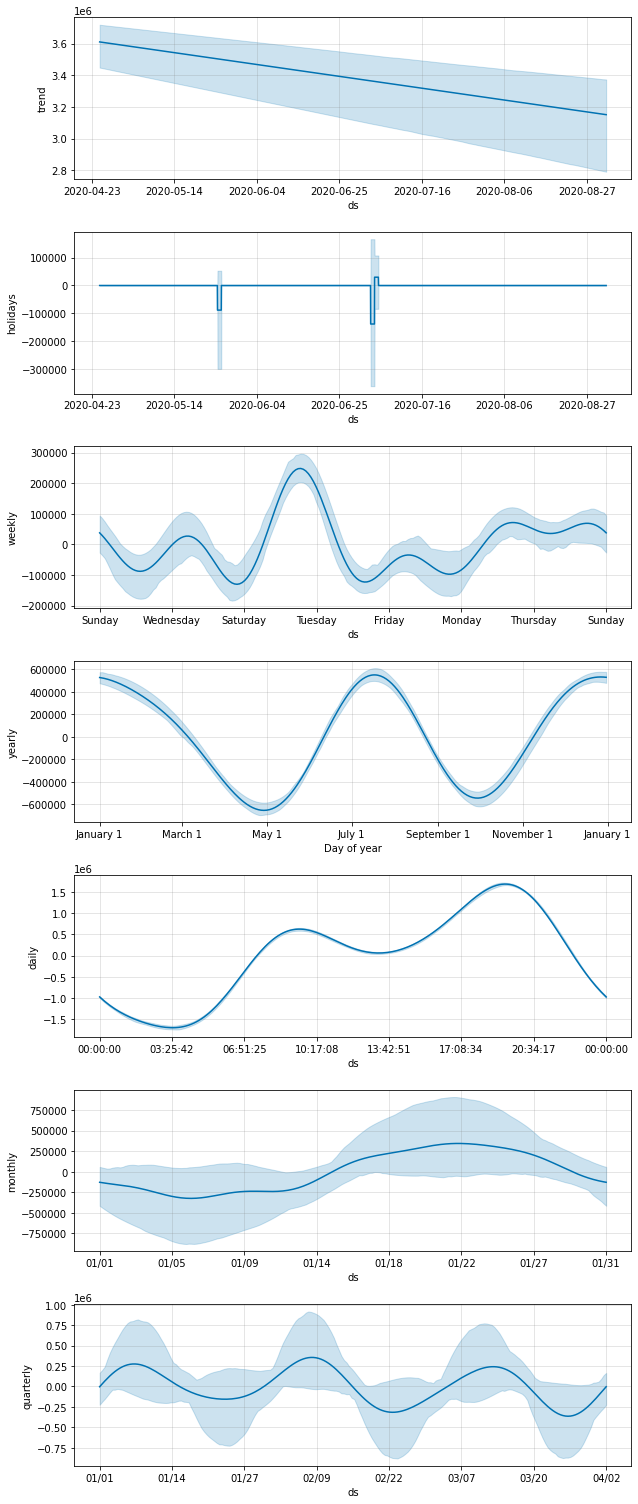

In [ ]:
fig2 = P_modello4.plot_components(predict_validation_4)

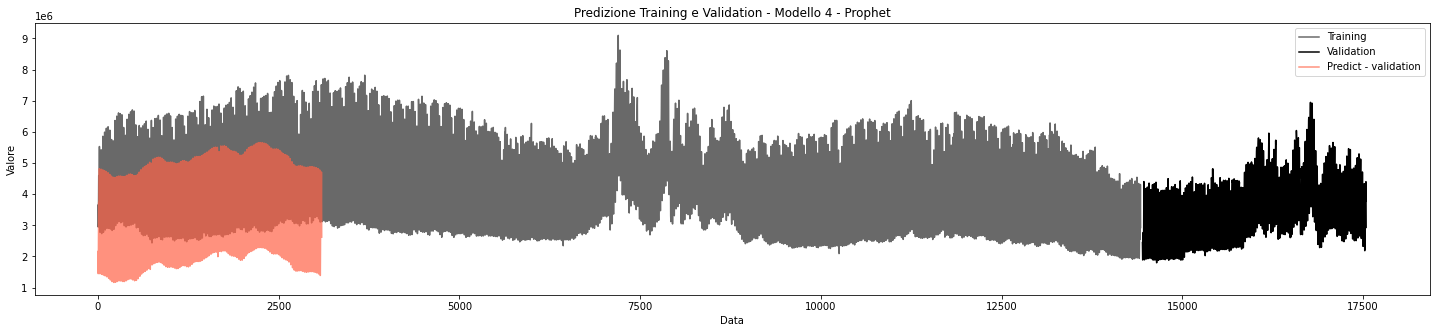

In [ ]:
plt.figure(figsize=(25, 5))
plt.title('Predizione Training e Validation - Modello 4 - Prophet')
plt.plot(train_dati['y'], color='dimgrey', label='Training')
plt.plot(validation_dati['y'], color='black', label='Validation')
plt.plot(predict_validation_4['yhat'], color='tomato', label='Predict - validation', alpha=0.7)
plt.ylabel('Valore')
plt.xlabel("Data")
plt.legend()
plt.show()

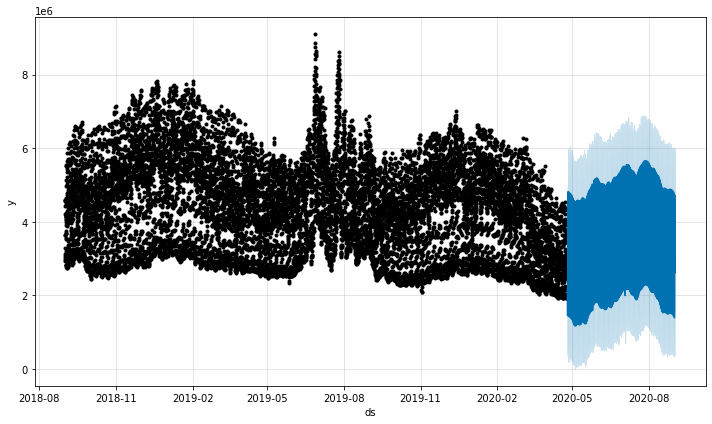

In [ ]:
fig = P_modello4.plot(predict_validation_4)

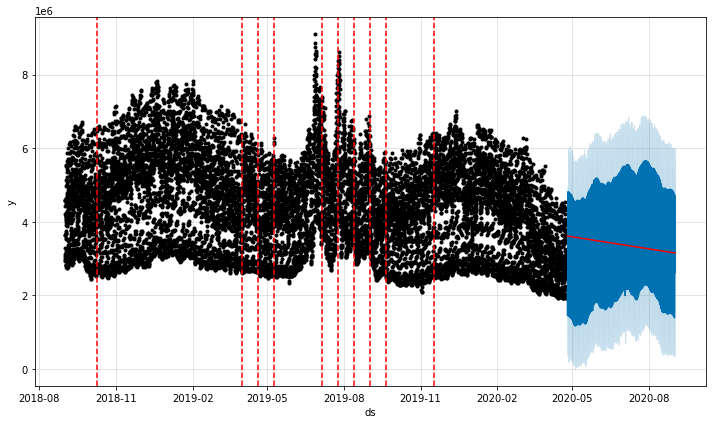

In [ ]:
forecast_4 = P_modello4.predict(future_4)
fig = P_modello4.plot(predict_validation_4)
a = add_changepoints_to_plot(fig.gca(), P_modello4, predict_validation_4)

In [ ]:
forecast_4[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
18835,2020-10-24 19:00:00,4.414305e+06,3.304619e+06,5.701062e+06
18836,2020-10-24 20:00:00,4.305267e+06,3.215995e+06,5.806925e+06
18837,2020-10-24 21:00:00,3.818460e+06,2.610650e+06,5.069780e+06
18838,2020-10-24 22:00:00,3.088593e+06,1.934366e+06,4.281955e+06
18839,2020-10-24 23:00:00,2.344736e+06,1.163601e+06,3.684367e+06


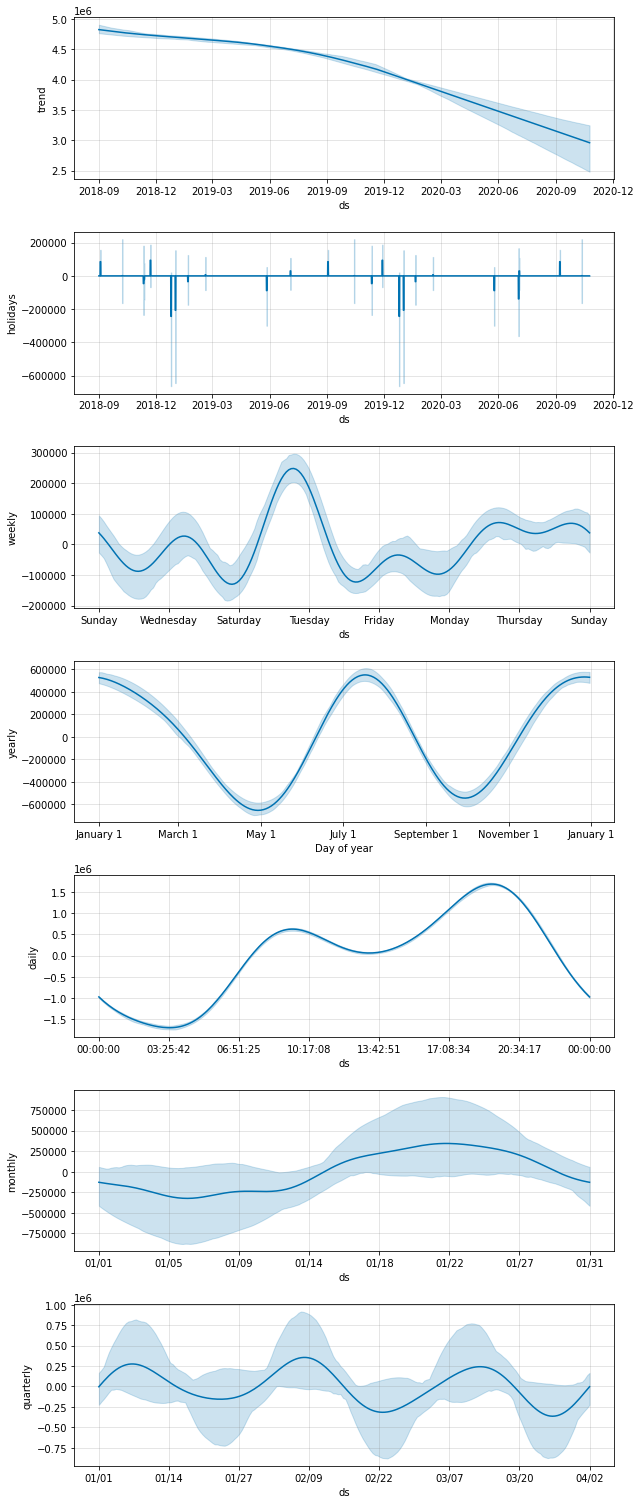

In [ ]:
fig2 = P_modello4.plot_components(forecast_4)

In [ ]:
from fbprophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(P_modello4, initial = '365 days', period = '60 days', horizon = '60 days')
df_cv.tail()

INFO:fbprophet:Making 3 forecasts with cutoffs between 2019-10-26 23:00:00 and 2020-02-23 23:00:00


To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
4315,2020-04-23 19:00:00,5.211369e+06,3.394625e+06,6.999250e+06,4005947.0,2020-02-23 23:00:00
4316,2020-04-23 20:00:00,5.079129e+06,3.290366e+06,6.693624e+06,4311509.0,2020-02-23 23:00:00
4317,2020-04-23 21:00:00,4.576942e+06,2.778781e+06,6.533103e+06,4032746.0,2020-02-23 23:00:00
4318,2020-04-23 22:00:00,3.841991e+06,2.147297e+06,5.742653e+06,3462387.0,2020-02-23 23:00:00
4319,2020-04-23 23:00:00,3.098066e+06,1.399087e+06,4.830148e+06,2928251.0,2020-02-23 23:00:00


In [ ]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,coverage
1292,59 days 20:00:00,9.293409e+11,964023.292953,764415.772139,0.213375,0.169805,0.932870
1293,59 days 21:00:00,9.351150e+11,967013.460933,767038.087075,0.214075,0.170083,0.932870
1294,59 days 22:00:00,9.380305e+11,968519.738546,768691.011194,0.214566,0.170083,0.932870
1295,59 days 23:00:00,9.378067e+11,968404.207964,769054.847456,0.214747,0.170083,0.935185
1296,60 days 00:00:00,9.359919e+11,967466.750376,768702.871917,0.214716,0.170083,0.935185


# Previsione con il modello 4

In [ ]:
P_modellodef = Prophet(yearly_seasonality= False, weekly_seasonality = False, daily_seasonality=False, mcmc_samples=30, changepoint_prior_scale=0.01, seasonality_prior_scale=0.01) 
P_modellodef.add_seasonality(name='weekly', period=168, fourier_order=5, prior_scale=0.1)
#buono mettendo nella seasonoality yearly 24*365,25 per il periodo
P_modellodef.add_seasonality(name='yearly', period=365.25, fourier_order=3, prior_scale=0.1)
P_modellodef.add_seasonality(name='quarterly', period=365.25/4, fourier_order=5, prior_scale=0.1)
P_modellodef.add_seasonality(name='daily', period=1, fourier_order=4, prior_scale=0.1)
P_modellodef.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.1)
P_modellodef.add_country_holidays(country_name='US')
P_modellodef.fit(dati)
print("-----------------------")
print("FIT FATTO")
print("-----------------------")
dfpre_predizioni_prophet = P_modellodef.make_future_dataframe(periods=1464,  freq='H', include_history=False)
print("-----------------------")
print("PREPARATE LE CONDIZIONI PER LE PREDIZIONI")
print("-----------------------")
print(dfpre_predizioni_prophet.tail())
previsioni_prophet = P_modellodef.predict(dfpre_predizioni_prophet)
print("-----------------------")
print("PREDIZIONI FATTE")
print("-----------------------")
print(previsioni_prophet.tail())

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


-----------------------
FIT FATTO
-----------------------
-----------------------
PREPARATE LE CONDIZIONI PER LE PREDIZIONI
-----------------------
                      ds
1459 2020-10-31 19:00:00
1460 2020-10-31 20:00:00
1461 2020-10-31 21:00:00
1462 2020-10-31 22:00:00
1463 2020-10-31 23:00:00
-----------------------
PREDIZIONI FATTE
-----------------------
                      ds  ...          yhat
1459 2020-10-31 19:00:00  ...  4.609973e+06
1460 2020-10-31 20:00:00  ...  4.529985e+06
1461 2020-10-31 21:00:00  ...  4.094283e+06
1462 2020-10-31 22:00:00  ...  3.417510e+06
1463 2020-10-31 23:00:00  ...  2.712438e+06

[5 rows x 67 columns]


In [ ]:
previsioni_prophet=previsioni_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
previsioni_prophet.drop(['yhat_lower', 'yhat_upper'], axis='columns', inplace=True)
previsioni_prophet.rename(columns={"ds": "Date", "yhat": "PROPHET"}, inplace=True)
print(previsioni_prophet.head())
print(previsioni_prophet.tail())

                 Date       PROPHET
0 2020-09-01 00:00:00  2.381395e+06
1 2020-09-01 01:00:00  2.019451e+06
2 2020-09-01 02:00:00  1.798021e+06
3 2020-09-01 03:00:00  1.663986e+06
4 2020-09-01 04:00:00  1.650518e+06
                    Date       PROPHET
1459 2020-10-31 19:00:00  4.609973e+06
1460 2020-10-31 20:00:00  4.529985e+06
1461 2020-10-31 21:00:00  4.094283e+06
1462 2020-10-31 22:00:00  3.417510e+06
1463 2020-10-31 23:00:00  2.712438e+06


In [ ]:
previsioni_prophet.to_csv('/content/drive/MyDrive/Data Science/Progetto Streaming Data/previsioni_prophet.csv', index = False)

In [ ]:
dati=pd.read_csv('/content/drive/MyDrive/Data Science/Progetto Streaming Data/dati_preprocessati.csv', header=0, low_memory=False, parse_dates=['DataeOra'])
dati.set_index('DataeOra', inplace=True)
dati.index.freq='H'
dati.head()

,Data,Ora,Valore,Mese,Giorno,Anno,Giornosettimana
DataeOra,,,,,,,
2018-09-01 00:00:00,2018-09-01,0,3646742.0,9,1,2018,Saturday
2018-09-01 01:00:00,2018-09-01,1,3273110.0,9,1,2018,Saturday
2018-09-01 02:00:00,2018-09-01,2,3069245.0,9,1,2018,Saturday
2018-09-01 03:00:00,2018-09-01,3,2969621.0,9,1,2018,Saturday
2018-09-01 04:00:00,2018-09-01,4,2944116.0,9,1,2018,Saturday


In [ ]:
previsioni_prophet.set_index('Date', inplace=True)
previsioni_prophet.index.freq='H'
previsioni_prophet.head()

,PROPHET
Date,
2020-09-01 00:00:00,2.431170e+06
2020-09-01 01:00:00,2.072758e+06
2020-09-01 02:00:00,1.865238e+06
2020-09-01 03:00:00,1.746655e+06
2020-09-01 04:00:00,1.740882e+06


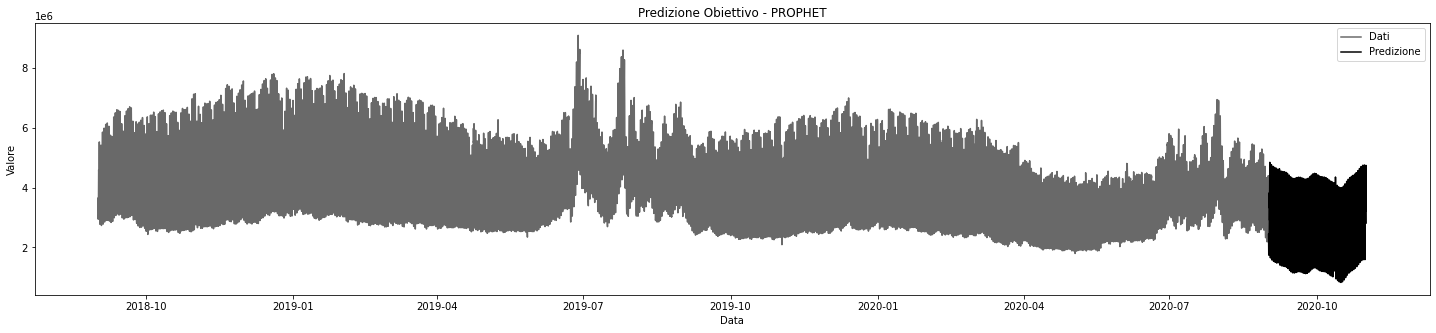

In [ ]:
plt.figure(figsize=(25, 5))
plt.title('Predizione Obiettivo - PROPHET')
plt.plot(dati['Valore'], color='dimgrey', label='Dati')
plt.plot(previsioni_prophet['PROPHET'], color='black', label='Predizione')
plt.ylabel('Valore')
plt.xlabel("Data")
plt.legend()
plt.show()